<a href="https://colab.research.google.com/github/jianchwe/Dacon-SDSS/blob/main/Dacon_SDSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**월간 데이콘 천체 유형 분류 대회**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Dacon_SDSS/'

### **2회차**
Random Forest 모델을 사용하여 전처리나 파생변수 없이 기본 상태로 학습시켜 성능의 기준점을 **확인**

In [ ]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

print(f"학습 데이터 크기: {train.shape}")
print(f"테스트 데이터 크기: {test.shape}")

학습 데이터 크기: (199991, 23)
테스트 데이터 크기: (10009, 22)


In [ ]:
le = LabelEncoder()
train['type'] = le.fit_transform(train['type'])

print(f"클래스 개수: {len(le.classes_)}")
print("클래스 목록 (앞 5개 - 알파벳순):", le.classes_[:5])

클래스 개수: 19
클래스 목록 (앞 5개 - 알파벳순): ['GALAXY' 'QSO' 'REDDEN_STD' 'ROSAT_D' 'SERENDIPITY_BLUE']


In [ ]:
X_train = train.drop(['id', 'type'], axis=1)
y_train = train['type']

X_test = test.drop(['id'], axis=1)

print(f"X_train shape: {X_train.shape}")

X_train shape: (199991, 21)


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
pred = model.predict_proba(X_test)

pred_classes = le.classes_

pred_df = pd.DataFrame(pred, columns=pred_classes)

for col in submission.columns:
    if col != 'id':
        submission[col] = pred_df[col]

In [ ]:
#파일 출력 전 확인
display(submission.head())

,id,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,199991,0.0,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.00,0.0,0.94,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00
1,199992,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.53,0.0,0.00,0.32,0.0,0.15,0.0,0.0,0.0,0.0,0.00
2,199993,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00
3,199994,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.06,0.0,0.00,0.05,0.0,0.04,0.0,0.0,0.0,0.0,0.85
4,199995,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00


In [ ]:
file_name = 'Dacon_SDSS_1.csv'
submission.to_csv(file_name, index=False)

### **2회차**
데이터 시각화를 통해 데이터의 이상치, 불균형을 전처리하여 정제된 데이터를 만들고 이를 통해 모델 재학습을 진행

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style("whitegrid")

데이터 시각화

/tmp/ipython-input-55184587.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=train, order=order, palette='viridis')


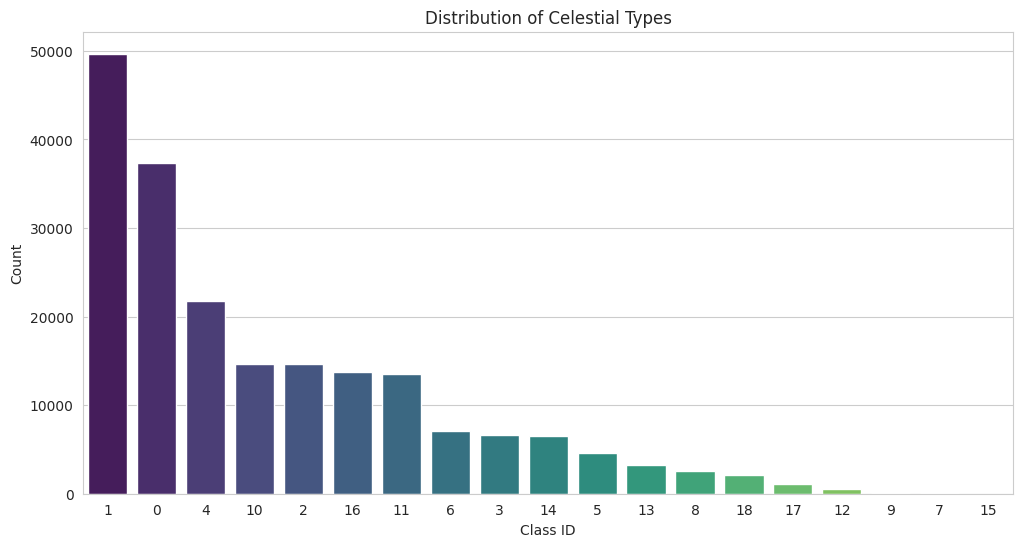

In [ ]:
plt.figure(figsize=(12, 6))

order = train['type'].value_counts().index
sns.countplot(x='type', data=train, order=order, palette='viridis')

plt.title("Distribution of Celestial Types")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

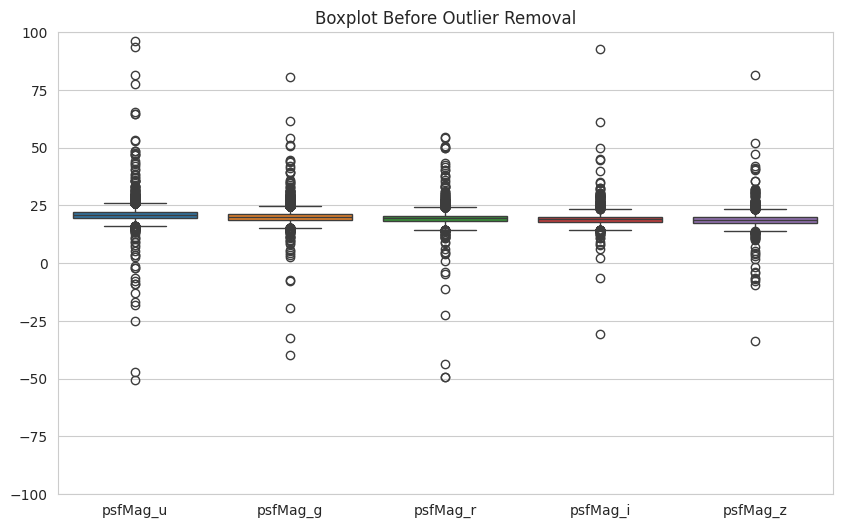

In [ ]:
mag_cols = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']

plt.figure(figsize=(10, 6))

sns.boxplot(data=train[mag_cols])

plt.title("Boxplot Before Outlier Removal")
plt.ylim(-100, 100)
plt.show()

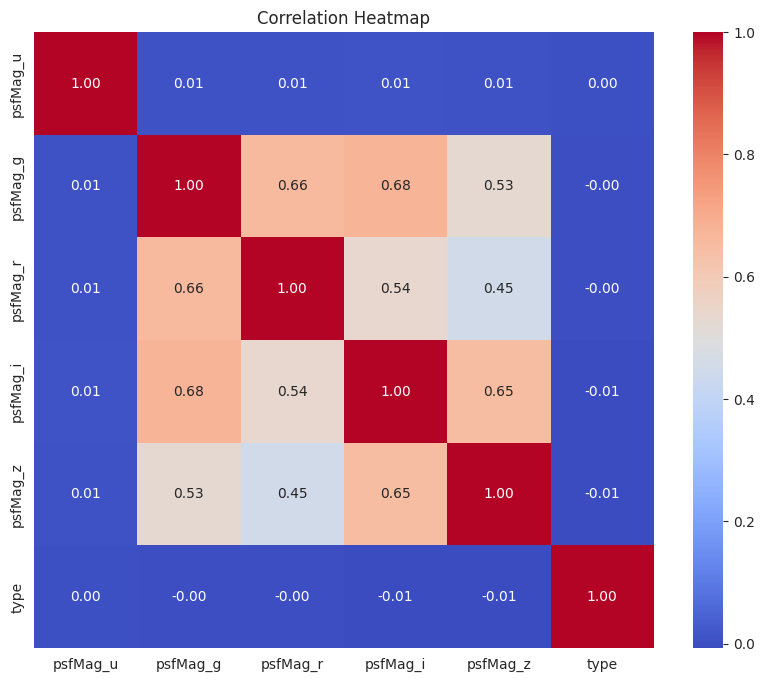

In [ ]:
plt.figure(figsize=(10, 8))

corr_cols = mag_cols + ['type']
corr = train[corr_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

이상치 제거

In [ ]:
print(f"데이터 개수: {len(train)}")

train_clean = train.copy()
for col in mag_cols:
    train_clean = train_clean[(train_clean[col] > -100) & (train_clean[col] < 100)]

print(f"데이터 개수: {len(train_clean)}")
print(f"이상치 개수: {len(train) - len(train_clean)}")

데이터 개수: 199991
데이터 개수: 199947
이상치 개수: 44


모델 재학습

In [ ]:
X_train_2 = train_clean.drop(['id', 'type'], axis=1)
y_train_2 = train_clean['type']
X_test = test.drop(['id'], axis=1)

In [ ]:
model_2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_2.fit(X_train_2, y_train_2)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
pred_2 = model_2.predict_proba(X_test)
pred_df_2 = pd.DataFrame(pred_2, columns=le.classes_)

submission_2 = pd.read_csv(path + 'sample_submission.csv')
for col in submission_2.columns:
    if col != 'id':
        submission_2[col] = pred_df_2[col]

In [ ]:
#파일 출력 전 확인
display(submission_2.head())

,id,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,199991,0.0,0.0,0.0,0.09,0.0,0.0,0.00,0.0,0.00,0.0,0.91,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00
1,199992,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.55,0.0,0.00,0.25,0.0,0.20,0.0,0.0,0.0,0.0,0.00
2,199993,0.0,0.0,0.0,0.00,0.0,0.0,0.97,0.0,0.00,0.0,0.00,0.03,0.0,0.00,0.0,0.0,0.0,0.0,0.00
3,199994,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.20,0.0,0.00,0.02,0.0,0.09,0.0,0.0,0.0,0.0,0.69
4,199995,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00


In [ ]:
file_name_2 = 'Dacon_SDSS_2.csv'
submission_2.to_csv(file_name_2, index=False)

### **3회차**
모델의 성능을 높일 수 있는 파생변수 생성

이 데이터에는 거리 정보가 들어있지 않지만
별의 색(파장의 차이)을 알면 온도를 추정할 수 있고

이를 통해 또 다른 분류를 만들어 낼 수 있음 -> 색 지수라는 변수를 만들어 추가

In [ ]:
train_FE = train_clean.copy()
test_FE = test.copy()

파생변수 생성

In [ ]:
def add_color_index(df):
    df['u_g'] = df['psfMag_u'] - df['psfMag_g']
    df['g_r'] = df['psfMag_g'] - df['psfMag_r']
    df['r_i'] = df['psfMag_r'] - df['psfMag_i']
    df['i_z'] = df['psfMag_i'] - df['psfMag_z']
    return df

In [ ]:
print("컬럼 수:", len(train_FE.columns))
train_FE = add_color_index(train_FE)
test_FE = add_color_index(test_FE)
print("컬럼 수:", len(train_FE.columns))

컬럼 수: 23
컬럼 수: 27


In [ ]:
print("\n[파생변수 샘플]")
display(train_FE[['psfMag_u', 'psfMag_g', 'u_g']].head())


[파생변수 샘플]


,psfMag_u,psfMag_g,u_g
0,23.198224,21.431953,1.766271
1,21.431355,20.708104,0.723251
2,17.851451,16.727898,1.123553
3,20.789900,20.040371,0.749529
4,26.454969,23.058767,3.396202


모델 재학습

In [ ]:
X_train_3 = train_FE.drop(['id', 'type'], axis=1)
y_train_3 = train_FE['type']
X_test_3 = test_FE.drop(['id'], axis=1)

In [ ]:
model_3 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_3.fit(X_train_3, y_train_3)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
pred_3 = model_3.predict_proba(X_test_3)
pred_df_3 = pd.DataFrame(pred_3, columns=le.classes_)

submission_3 = pd.read_csv(path + 'sample_submission.csv')

for col in submission_3.columns:
    if col != 'id':
        submission_3[col] = pred_df_3[col]

In [ ]:
#파일 출력 전 확인
display(submission_3.head())

,id,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,199991,0.0,0.0,0.0,0.33,0.0,0.0,0.00,0.0,0.01,0.0,0.66,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00
1,199992,0.0,0.0,0.0,0.00,0.0,0.0,0.02,0.0,0.56,0.0,0.00,0.22,0.0,0.20,0.0,0.0,0.0,0.0,0.00
2,199993,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00
3,199994,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.12,0.0,0.00,0.02,0.0,0.02,0.0,0.0,0.0,0.0,0.84
4,199995,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,1.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00


In [ ]:
file_name_3 = 'Dacon_SDSS_3.csv'
submission_3.to_csv(file_name_3, index=False)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

데이터 분할 (train : val = 8 : 2)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_3, y_train_3,
    test_size=0.2,
    random_state=42,
    stratify=y_train_3
)

In [ ]:
model_val = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_val.fit(X_tr, y_tr)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
pred_val = model_val.predict_proba(X_val)

LogLoss 점수 예측

In [ ]:
score = log_loss(y_val, pred_val)
print(f"LogLoss 예상 점수 : {score:.5f}")

LogLoss 예상 점수 : 0.47866


### **4회차**
기존 Random Forest이 더 이상 점수변화가 크지 않음을 인지하였으니

LightGBM 이라는 모델을 사용하도록 교체 시도 및 Random Forest vs LightGBM 모델의 성능 비교

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np

In [ ]:
X_tr_np = X_tr.values
y_tr_np = y_tr
X_val_np = X_val.values
y_val_np = y_val
X_test_np = X_test_3.values

print(f"Numpy 크기: {X_tr_np.shape}")
print(f"클래스 개수: {len(np.unique(y_tr_np))}")

Numpy 크기: (159957, 25)
클래스 개수: 19


In [ ]:
lgbm = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=128,
    objective='multiclass',
    num_class=19,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [ ]:
lgbm.fit(
    X_tr_np, y_tr_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric='multi_logloss'
)

LGBMClassifier(learning_rate=0.01, n_estimators=2000, n_jobs=-1, num_class=19,
               num_leaves=128, objective='multiclass', random_state=42,
               verbose=-1)

In [ ]:
val_prob = lgbm.predict_proba(X_val_np)
val_score = log_loss(y_val_np, val_prob)

print(f"LogLoss 예상 점수 : {val_score:.5f}")

LogLoss 예상 점수 : 0.43038


In [ ]:
pred_4 = lgbm.predict_proba(X_test_np)
pred_df_4 = pd.DataFrame(pred, columns=le.classes_)

submission_4 = pd.read_csv(path + 'sample_submission.csv')

for col in submission_4.columns:
    if col != 'id':
        submission_4[col] = pred_df[col]

In [ ]:
#파일 출력 전 확인
display(submission_4.head())

,id,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
0,199991,6.573689e-10,6.258232e-11,7.629823e-10,7.089847e-04,6.093918e-09,3.785153e-10,1.968282e-08,1.753474e-08,7.977395e-06,2.877039e-12,9.992560e-01,2.698288e-05,1.388063e-14,2.092865e-08,9.360336e-11,1.282126e-09,2.004422e-10,6.565698e-10,2.082090e-08
1,199992,1.269819e-06,3.636283e-08,4.632136e-09,1.528292e-08,7.207556e-07,2.658132e-06,6.052120e-05,7.627090e-06,7.209794e-01,1.757500e-09,7.106092e-09,1.732364e-01,4.797926e-10,1.057077e-01,1.050075e-07,7.969191e-07,1.121641e-08,2.204105e-08,2.747202e-06
2,199993,6.450534e-08,1.963873e-09,1.551585e-11,1.670239e-11,3.117106e-09,4.350851e-09,9.999024e-01,1.470159e-08,6.720198e-05,5.538093e-12,2.189253e-11,2.615553e-05,3.763992e-14,4.082826e-06,5.374912e-09,8.335727e-10,6.896158e-12,7.795385e-11,2.742658e-08
3,199994,9.573727e-07,7.357307e-09,1.692141e-09,4.024292e-09,3.940119e-08,8.105683e-07,1.937535e-06,4.335745e-05,6.540085e-02,8.741857e-10,1.474213e-09,4.149172e-03,2.574098e-10,2.859875e-03,5.050694e-09,3.212506e-08,8.555601e-10,2.284443e-09,9.275429e-01
4,199995,8.750048e-13,3.047261e-14,8.372798e-14,8.077718e-13,1.109124e-12,9.941041e-13,1.588458e-11,9.904559e-12,6.569233e-09,2.201872e-15,1.000000e+00,3.044508e-08,8.547091e-18,1.081629e-10,1.428673e-14,7.310047e-13,1.399375e-14,4.292744e-14,9.884628e-12


In [ ]:
file_name_4 = 'Dacon_SDSS_4.csv'
submission.to_csv(file_name_4, index=False)

####RandomForest vs LightGBM 비교

LogLoss 비교

In [ ]:
lgbm_score = val_score

results = {
    "Model": ["RandomForest", "LightGBM"],
    "LogLoss": [0.47866, lgbm_score],
    "Note": ["3회차", "4회차"]
}

In [ ]:
df_results = pd.DataFrame(results)
print("\n[모델 성능 비교표]")
display(df_results)


[모델 성능 비교표]


,Model,LogLoss,Note
0,RandomForest,0.478660,3회차
1,LightGBM,0.430384,4회차


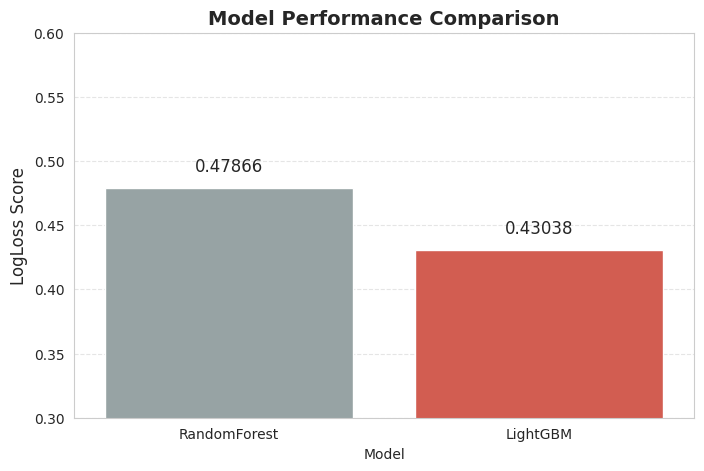

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Model", y="LogLoss", data=df_results, palette=["#95a5a6", "#e74c3c"])

plt.title("Model Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("LogLoss Score", fontsize=12)
plt.ylim(0.3, 0.6)

for i, v in enumerate(df_results["LogLoss"]):
    ax.text(i, v + 0.01, f"{v:.5f}", ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

변수 중요도 비교

In [ ]:
features = train_FE.drop(['id', 'type'], axis=1).columns.tolist()

RandomForest 변수 중요도

In [ ]:
rf_imp = pd.DataFrame({
    'Feature': features,
    'Importance': model_3.feature_importances_,
    'Model': 'RandomForest'
})

LightGBM 변수 중요도

In [ ]:
lgbm_val = lgbm.feature_importances_
lgbm_imp = pd.DataFrame({
    'Feature': features,
    'Importance': lgbm_val / lgbm_val.sum(),
    'Model': 'LightGBM'
})

두 모델의 중요도 비교

In [ ]:
combined_imp = pd.concat([rf_imp, lgbm_imp])

In [ ]:
plt.figure(figsize=(12, 8))

top_features = combined_imp.groupby('Feature')['Importance'].sum().sort_values(ascending=False).head(10).index
plot_data = combined_imp[combined_imp['Feature'].isin(top_features)]

<Figure size 1200x800 with 0 Axes>

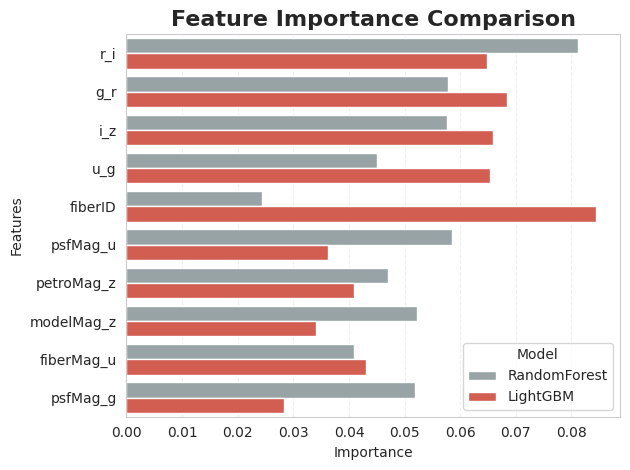

In [ ]:
colors = {'RandomForest': '#95a5a6', 'LightGBM': '#e74c3c'}

sns.barplot(x="Importance", y="Feature", hue="Model", data=plot_data,
            order=top_features, palette=colors)

plt.title('Feature Importance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.legend(title='Model', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

###**5회차**

Hyperparameter tuning 과정을 실행하여 점수를 낮추도록 해본다

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
X = train_FE.drop(['id', 'type'], axis=1)
y = train_FE['type']

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'num_leaves': trial.suggest_int('num_leaves', 30, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'n_jobs': -1,
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMClassifier(**params, verbose=-1)
        model.fit(X_train_fold, y_train_fold)

        preds = model.predict_proba(X_val_fold)
        score = log_loss(y_val_fold, preds)
        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print(f"BEST SCORE (LogLoss): {study.best_value:.5f}")
print(study.best_params)

optuna 실행 실패

In [ ]:
best_params = study.best_params

final_model = LGBMClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [ ]:
final_model.fit(X, y)

In [ ]:
if 'test_FE' in globals():
    X_test_final = test_FE.drop(['id'], axis=1)
else:
    print("test_FE 변수가 없어서 로드합니다 (경로 확인 필요)")
    test_FE = pd.read_csv(path + 'test.csv')
    X_test_final = test_FE.drop(['id'], axis=1)

In [ ]:
pred_final = final_model.predict_proba(X_test_final)

In [ ]:
submission_final = pd.read_csv(path + 'sample_submission.csv')

for col in submission_final.columns:
    if col != 'id':
        submission_final[col] = pd.DataFrame(pred_final, columns=le.classes_)[col]

filename = 'Dacon_SDSS_5.csv'
submission_final.to_csv(filename, index=False)

optuna 실행 실패로 params 직접 지정해서 실행하여 추가 제출해보기로 함

In [ ]:
manual_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_leaves': 60,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

In [ ]:
X = train_FE.drop(['id', 'type'], axis=1)
y = train_FE['type']

In [ ]:
final_model = LGBMClassifier(**manual_params, verbose=-1)
final_model.fit(X, y)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=10,
               n_estimators=500, n_jobs=-1, num_leaves=60, random_state=42,
               subsample=0.8, verbose=-1)

In [ ]:
if 'test_FE' not in globals():
    test_FE = pd.read_csv(path + 'test.csv')
    bands = ['u', 'g', 'r', 'i', 'z']
    for i in range(len(bands)-1):
        test_FE[f'{bands[i]}_{bands[i+1]}'] = test_FE[f'psfMag_{bands[i]}'] - test_FE[f'psfMag_{bands[i+1]}']
    X_test = test_FE.drop(['id'], axis=1)
else:
    X_test = test_FE.drop(['id'], axis=1)

pred_final = final_model.predict_proba(X_test)

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
for i, col in enumerate(final_model.classes_):
    submission[col] = pred_final[:, i]

filename = 'Dacon_SDSS_5.csv'
submission.to_csv(filename, index=False)